# Various examinations of US public debt

In [1]:
fn = 'MSPD_all_tables_20010131_20240331/MSPD_DetailSecty_20010131_20240331.csv'

import pandas as pd

df_all = pd.read_csv(fn, low_memory=False)
df_all['Record Date'].min(), df_all['Record Date'].max()

('2001-01-31', '2024-03-31')

In [2]:
def f(rdt):
    df = df_all[df_all['Record Date'] == rdt]
    df = df[(~df['Outstanding Amount (in Millions)'].isna()) & (~df['Maturity Date'].isna())]

    df2 = df[['Yield', 'Outstanding Amount (in Millions)']].astype(float)

    return (df2['Yield'] * df2['Outstanding Amount (in Millions)']).sum() / df2[
        'Outstanding Amount (in Millions)'].sum()


print(f'Current weighted yield:', f(df_all['Record Date'].max()))



Current weighted yield: 2.9669052586363236


2001-01-31
2001-02-28


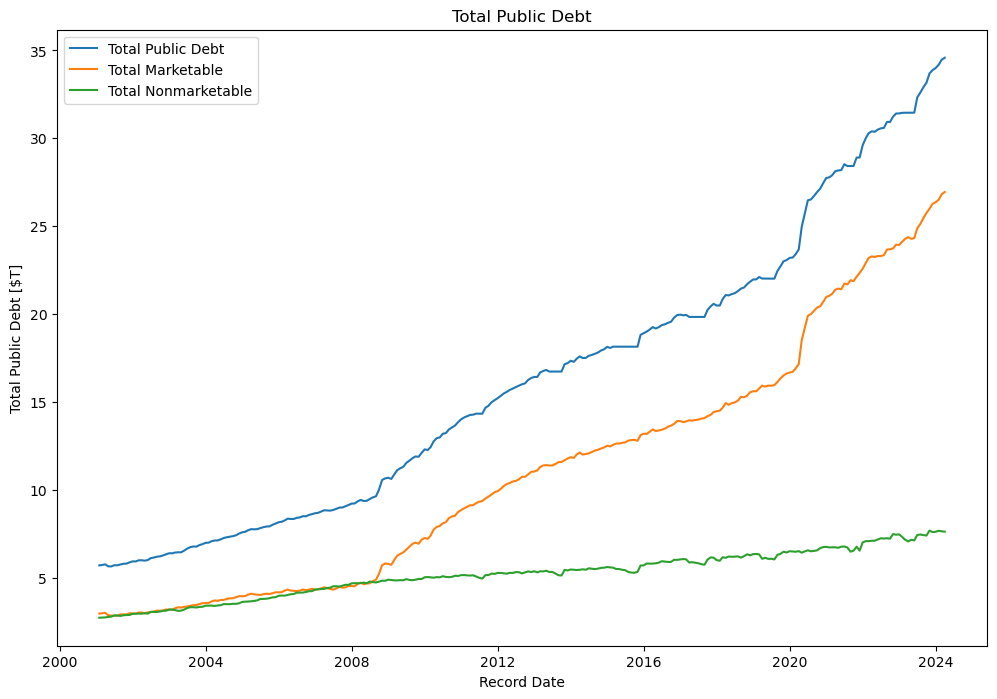

In [3]:
def f():
    lst = []
    for rdt in sorted(df_all['Record Date'].unique()):
        df = df_all[df_all['Record Date'] == rdt]

        total_marketable = \
            df[(df['Security Class 1 Description'] == 'Total Marketable')]['Outstanding Amount (in Millions)'].astype(
                float).iloc[0]
        total_nonmarketable = df[(df['Security Class 1 Description'] == 'Total Nonmarketable')][
            'Current Month Outstanding Amount (in Millions)'].astype(float).iloc[0]
        try:
            total_public_debt = df[(df['Security Class 1 Description'] == 'Total Public Debt Outstanding')][
                'Current Month Outstanding Amount (in Millions)'].astype(float).iloc[0]
        except IndexError:
            print(rdt)
            total_public_debt = total_marketable + total_nonmarketable

        from datetime import datetime
        lst += [(datetime.strptime(rdt, "%Y-%m-%d").date(), total_public_debt, total_marketable, total_nonmarketable)]

    df = pd.DataFrame(lst, columns=['Record Date', 'Total Public Debt', 'Total Marketable', 'Total Nonmarketable'])
    df[['Total Public Debt', 'Total Marketable', 'Total Nonmarketable']] /= 1_000_000
    return df


f().plot(x='Record Date', figsize=(12, 8), title='Total Public Debt', ylabel='Total Public Debt [$T]',
         xlabel='Record Date');


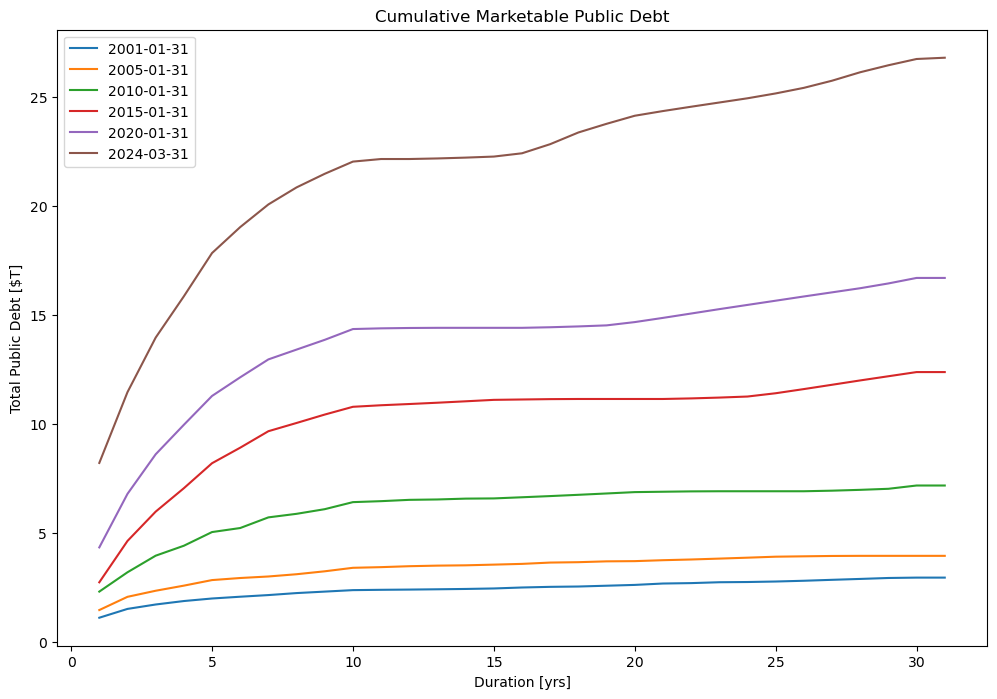

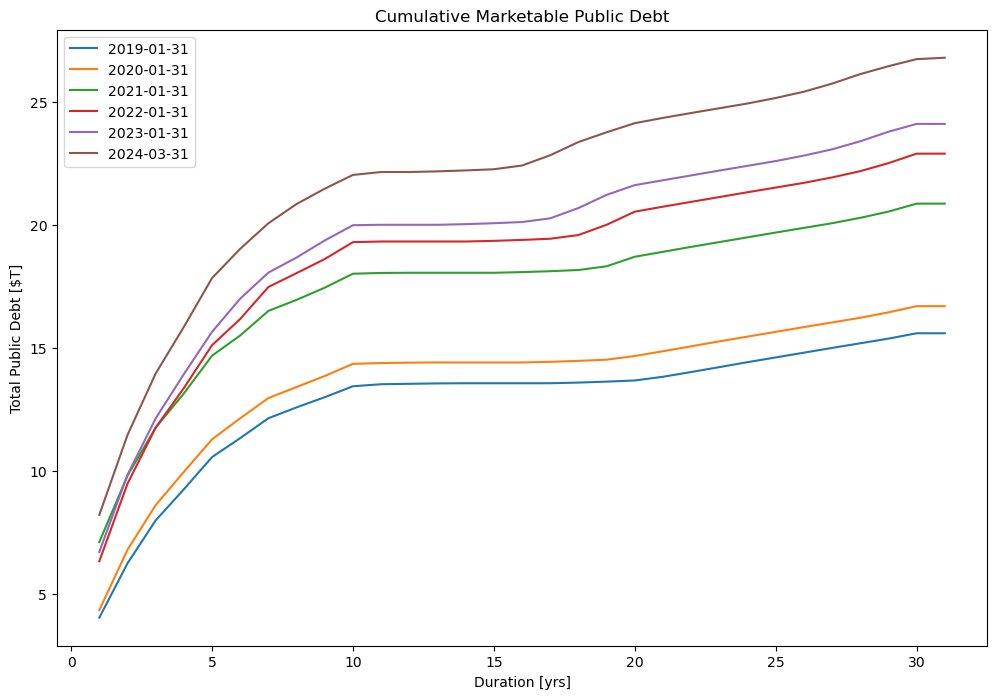

In [4]:
def f(rdts, cumulative=True):
    df1 = df_all[(df_all['Security Type Description'] == 'Marketable') & (df_all['Maturity Date'].notna())]

    lst2 = []

    for rdt in rdts:
        df2 = df1[df1['Record Date'] == rdt]

        yrs = sorted(set(x[:4] for x in df2['Maturity Date'].unique()))

        lst = []
        for yr in yrs:
            df3 = df2[df2['Maturity Date'].str.startswith(yr)]
            lst += [(int(yr),
                     df3[df3['Outstanding Amount (in Millions)'].notna()]['Outstanding Amount (in Millions)'].astype(
                         float).sum())]

        df4 = pd.DataFrame(lst, columns=['yr', rdt])
        df4['duration'] = df4['yr'] - int(rdt[:4]) + 1
        df4 = df4.drop(columns=['yr'])
        df4 = df4.set_index('duration', drop=True)
        df5 = df4.cumsum() if cumulative else df4
        lst2 += [df5]

    dff = pd.concat(lst2, ignore_index=False, axis=1) / 1_000_000
    dff = dff.sort_index()
    dff = dff.ffill()
    title = 'Cumulative Marketable Public Debt' if cumulative else 'Marketable Public Debt'
    dff.plot(figsize=(12, 8), title=title, ylabel='Total Public Debt [$T]', xlabel='Duration [yrs]')


f(['2001-01-31', '2005-01-31', '2010-01-31', '2015-01-31', '2020-01-31', '2024-03-31'])
f(['2019-01-31', '2020-01-31', '2021-01-31', '2022-01-31', '2023-01-31', '2024-03-31'])


# Cumulative effect of renewing maturing marketable debt at higher yield
Assume no additional debt. TIPS are not handled properly.

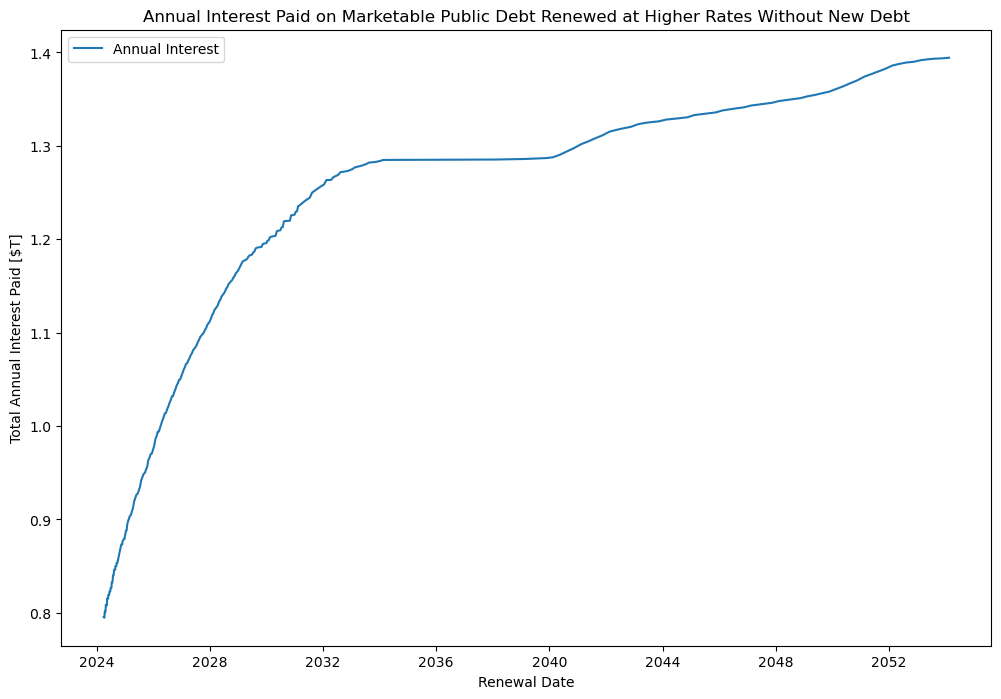

In [5]:
def f(rdt, new_yield):
    df = df_all[df_all['Record Date'] == rdt]
    df = df[(~df['Outstanding Amount (in Millions)'].isna()) & (~df['Maturity Date'].isna())]
    # df[['Security Class 1 Description', 'Security Class 2 Description', 'Yield', 'Interest Rate', 'Issue Date', 'Maturity Date', 'Outstanding Amount (in Millions)']]

    df2 = df[['Yield', 'Maturity Date', 'Outstanding Amount (in Millions)']].sort_values('Maturity Date')
    df2 = df2.copy()

    def g():
        return ((df2['Yield'] / 100) * df2['Outstanding Amount (in Millions)'].astype(float)).sum() / 1_000_000

    from datetime import datetime
    lst = [(datetime.strptime(df2['Maturity Date'].min(), "%Y-%m-%d").date(), g())]

    for dt in sorted(df2['Maturity Date']):
        df2.loc[df2['Maturity Date'] == dt, 'Yield'] = new_yield
        lst += [(datetime.strptime(dt, "%Y-%m-%d").date(), g())]

    return pd.DataFrame(lst, columns=['Renewal Date', 'Annual Interest'])


f(df_all['Record Date'].max(), 5.2).plot(x='Renewal Date', y='Annual Interest', figsize=(12, 8),
                                         title='Annual Interest Paid on Marketable Public Debt Renewed at Higher Rates Without New Debt',
                                         ylabel='Total Annual Interest Paid [$T]',
                                         xlabel='Renewal Date');

